In [1]:
# =============================================================================
# NOTEBOOK SETUP - Two Population Delay Sweep Execution
# =============================================================================
import os
import sys
from pathlib import Path

# Robust directory setup
if Path.cwd().name == 'two_populations':
    os.chdir("../../")
    
from src.two_populations.helpers.logger import setup_logger

logger = setup_logger(
    experiment_name="delay_sweep_gaussian",
    console_level="INFO",
    file_level="DEBUG",
    log_to_file=False
)

logger.info(f"Working directory: {Path.cwd()}")
logger.info(f"Python path: {sys.path[0]}")

INFO     | __main__:<module>:21 - Working directory: /home/ubuntu-deduce/Projects/izhikevich
INFO     | __main__:<module>:22 - Python path: /home/ubuntu-deduce/.asdf/installs/python/3.10.13/lib/python310.zip


In [2]:
# =============================================================================
# EXPERIMENT DISCOVERY AND SELECTION
# =============================================================================

def discover_experiments(base_dir='./results/experiments/two_populations/step_input'):
    """Discover and categorize available experiment directories"""
    
    if not os.path.exists(base_dir):
        logger.info(f"Directory not found: {base_dir}")
        return {}
    
    all_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    experiments = {
        'uniform': [d for d in all_dirs if 'UNIFORM' in d],
        'gaussian': [d for d in all_dirs if 'GAUSS' in d],
        'beta': [d for d in all_dirs if 'BETA' in d],
        'delta': [d for d in all_dirs if 'DELTA' in d]
    }
    
    # Summary
    total = sum(len(exps) for exps in experiments.values())
    logger.info(f"Found {total} experiments:")
    for delay_type, dirs in experiments.items():
        if dirs:
            logger.info(f"  {delay_type.capitalize()}: {len(dirs)} experiments")
    
    return experiments

def filter_experiments(experiments, coupling=None, date_range=None):
    """Filter experiments by coupling strength or date"""
    
    filtered = {}
    for delay_type, dirs in experiments.items():
        if coupling:
            dirs = [d for d in dirs if coupling.upper() in d]
        
        if date_range and len(date_range) == 2:
            # Filter by date range in directory name
            start_date, end_date = date_range
            dirs = [d for d in dirs 
                   if any(start_date <= date <= end_date 
                         for date in d.split('_')[-2:] if date.isdigit())]
        
        filtered[delay_type] = dirs
    
    return filtered

def display_experiment_details(experiments, max_display=3):
    """Display experiment details in organized format"""
    
    for delay_type, dirs in experiments.items():
        if not dirs:
            continue
            
        logger.info(f"\n{delay_type.upper()} EXPERIMENTS ({len(dirs)} total)")
        logger.info("-" * 50)
        
        for i, dir_name in enumerate(dirs[:max_display]):
            # Parse experiment info
            parts = dir_name.split('_')
            
            coupling = next((p for p in parts if p in ['WEAK', 'MEDIUM', 'SEMISTRONG', 'STRONG']), 'Unknown')
            date_time = '_'.join(parts[-2:]) if len(parts) >= 2 else 'Unknown'
            
            logger.info(f"  {i+1}. {coupling} coupling - {date_time}")
            logger.info(f"     Full path: {dir_name}")
        
        if len(dirs) > max_display:
            logger.info(f"     ... and {len(dirs) - max_display} more")

# Discover available experiments
experiments = discover_experiments()

# Example filters (uncomment to use)
strong_experiments = filter_experiments(experiments, coupling='STRONG')
recent_experiments = filter_experiments(experiments, date_range=('20250919', '20250925'))

# Display details
display_experiment_details(strong_experiments)

INFO     | __main__:discover_experiments:23 - Found 42 experiments:
INFO     | __main__:discover_experiments:26 -   Uniform: 8 experiments
INFO     | __main__:discover_experiments:26 -   Gaussian: 19 experiments
INFO     | __main__:discover_experiments:26 -   Beta: 6 experiments
INFO     | __main__:discover_experiments:26 -   Delta: 9 experiments
INFO     | __main__:display_experiment_details:56 - 
UNIFORM EXPERIMENTS (4 total)
INFO     | __main__:display_experiment_details:57 - --------------------------------------------------
INFO     | __main__:display_experiment_details:66 -   1. STRONG coupling - 20250919_184655
INFO     | __main__:display_experiment_details:67 -      Full path: MS_UNIFORM_1_SAME_NOISE_CI_STEP_STRONG_2p0_k3p5_dt0p1_T4000_30trials__20250919_184655
INFO     | __main__:display_experiment_details:66 -   2. STRONG coupling - 20250922_142717
INFO     | __main__:display_experiment_details:67 -      Full path: MS_UNIFORM_2_SAME_NOISE_CI_STEP_STRONG_2p0_k3p5_dt0p1_T4000_3

In [3]:
from src.two_populations.helpers.helpers import load_results_from_csvs, load_trials_data_for_dashboard

# =============================================================================
# EXPERIMENT ANALYSIS
# =============================================================================

def analyze_experiment(sweep_dir, experiment_name=None):
    """Load and analyze a specific experiment"""
    
    if not os.path.exists(sweep_dir):
        logger.info(f"Directory not found: {sweep_dir}")
        return None, None, None
    
    # Get configurations
    config_dirs = [d for d in os.listdir(sweep_dir) if d.startswith('config_')]
    completed_configs = [d.replace('config_', '') for d in config_dirs]
    
    if not completed_configs:
        logger.info(f"No completed configs found in {sweep_dir}")
        return None, None, None
    
    logger.info(f"Analyzing experiment: {experiment_name or 'Selected experiment'}")
    logger.info(f"Directory: {sweep_dir}")
    logger.info(f"Found {len(completed_configs)} configurations")
    
    # Load results
    results_db = load_results_from_csvs(sweep_dir, completed_configs, filter_outliers=False)
    trials_data = load_trials_data_for_dashboard(sweep_dir, completed_configs)
    
    return results_db, trials_data, completed_configs

# =============================================================================
# SELECT EXPERIMENT TO ANALYZE
# =============================================================================

# Option 1: Select from discovered experiments
# experiment_dir = experiments['delta'][0]  # First uniform experiment
# sweep_dir = f"./results/experiments/two_populations/step_input_diff_rois/{experiment_dir}"

# Option 2: Specify directly (replace with your experiment)
sweep_dir = './results/experiments/two_populations/step_input_diff_rois/20251006_172926/MS_LOGNORMAL_STRONG_k3p5_dt0p1_T4000_20trials__'

# Load and analyze
results_db, trials_data, completed_configs = analyze_experiment(sweep_dir, "DELTA MEDIUM")

if results_db is not None:
    logger.info(f"Analysis ready: {len(results_db)} configurations loaded")
    
    # Quick summary
    for config, data in list(results_db.items())[:3]:
        agg = data.get('aggregated', {})
        cc_peak = agg.get('cross_corr_peak', {}).get('mean', 0)
        plv_alpha = agg.get('plv_alpha', {}).get('mean', 0)
        logger.info(f"  {config[:40]}... CC={cc_peak:.3f}, PLV={plv_alpha:.3f}")
        
    if len(results_db) > 3:
        logger.info(f"  ... and {len(results_db)-3} more configurations")
else:
    logger.info("Analysis failed - check directory path")

INFO     | __main__:analyze_experiment:22 - Analyzing experiment: DELTA MEDIUM
INFO     | __main__:analyze_experiment:23 - Directory: ./results/experiments/two_populations/step_input_diff_rois/20251006_172926/MS_LOGNORMAL_STRONG_k3p5_dt0p1_T4000_20trials__
INFO     | __main__:analyze_experiment:24 - Found 5 configurations
INFO     | __main__:<module>:47 - Analysis ready: 5 configurations loaded
INFO     | __main__:<module>:54 -   MS_STRONG_step_input_lognorm_1p1-0p3... CC=0.577, PLV=0.770
INFO     | __main__:<module>:54 -   MS_STRONG_step_input_lognorm_1p5-0p7... CC=0.530, PLV=0.758
INFO     | __main__:<module>:54 -   MS_STRONG_step_input_lognorm_1p6-0p4... CC=0.555, PLV=0.761
INFO     | __main__:<module>:57 -   ... and 2 more configurations


In [4]:
# =============================================================================
# DEBUG AND DATA INSPECTION (Optional)
# =============================================================================
import pickle
import numpy as np

def inspect_raw_data(sweep_dir, config_name=None, trial=1):
    """Inspect raw trial data for debugging"""
    
    if config_name is None:
        # Auto-select first config
        config_dirs = [d for d in os.listdir(sweep_dir) if d.startswith('config_')]
        if not config_dirs:
            logger.info("No config directories found")
            return None
        config_name = config_dirs[0].replace('config_', '')
    
    # Try to load raw pickle file
    trial_file = f"{sweep_dir}/figures/{config_name}/trial_{trial}_full.pkl"
    
    if not os.path.exists(trial_file):
        logger.info(f"Raw data file not found: {trial_file}")
        return None
    
    try:
        with open(trial_file, 'rb') as f:
            data = pickle.load(f)
        
        logger.info(f"Raw data loaded from: {trial_file}")
        logger.info(f"Available keys: {list(data.keys())}")
        
        # Quick data summary
        if 'rate_A' in data:
            logger.info(f"Rate A shape: {np.array(data['rate_A']).shape}")
        if 'rate_B' in data:
            logger.info(f"Rate B shape: {np.array(data['rate_B']).shape}")
        if 'cross_correlation' in data:
            cc = data['cross_correlation']
            if isinstance(cc, dict):
                logger.info(f"Cross-correlation peak: {cc.get('peak_value', 'N/A')}")
            
        return data
        
    except Exception as e:
        logger.info(f"Error loading raw data: {e}")
        return None

# =============================================================================
# CUSTOM ANALYSIS FUNCTIONS
# =============================================================================

def compare_configurations(results_db, metric='plv_alpha', top_n=3):
    """Compare top and bottom configurations for a specific metric"""
    
    if not results_db:
        return
    
    configs = []
    for config, data in results_db.items():
        agg = data.get('aggregated', {})
        value = agg.get(metric, {}).get('mean', 0)
        readable = data.get('readable_name', config[:40])
        configs.append((config, readable, value))
    
    configs.sort(key=lambda x: x[2], reverse=True)
    
    logger.info(f"\nTop {top_n} configurations by {metric}:")
    for i, (config, readable, value) in enumerate(configs[:top_n], 1):
        logger.info(f"{i}. {readable}: {value:.3f}")
    
    logger.info(f"\nBottom {top_n} configurations by {metric}:")
    for i, (config, readable, value) in enumerate(configs[-top_n:], 1):
        logger.info(f"{i}. {readable}: {value:.3f}")

def get_experiment_summary(results_db):
    """Get comprehensive experiment summary"""
    
    if not results_db:
        return
    
    metrics = ['cross_corr_peak', 'plv_alpha', 'coherence_peak', 'tau_A', 'tau_B']
    
    logger.info(f"\nEXPERIMENT SUMMARY ({len(results_db)} configurations)")
    logger.info("=" * 60)
    # 
    for metric in metrics:
        values = []
        for data in results_db.values():
            agg = data.get('aggregated', {})
            val = agg.get(metric, {}).get('mean', 0)
            if val != 0:  # Filter out missing values
                values.append(val)
        
        if values:
            logger.info(f"{metric:15}: {np.mean(values):.3f} ± {np.std(values):.3f} "
                f"[{np.min(values):.3f}, {np.max(values):.3f}]")

# Execute analysis functions if data is available
if 'results_db' in locals() and results_db:
    get_experiment_summary(results_db)
    compare_configurations(results_db, 'plv_alpha')
    compare_configurations(results_db, 'cross_corr_peak')
    
    # Uncomment to inspect raw data
    raw_data = inspect_raw_data(sweep_dir)

INFO     | __main__:get_experiment_summary:83 - 
EXPERIMENT SUMMARY (5 configurations)
INFO     | __main__:get_experiment_summary:84 - ============================================================
INFO     | __main__:get_experiment_summary:95 - cross_corr_peak: 0.548 ± 0.028 [0.503, 0.577]
INFO     | __main__:get_experiment_summary:95 - plv_alpha      : 0.764 ± 0.005 [0.758, 0.771]
INFO     | __main__:get_experiment_summary:95 - coherence_peak : 0.914 ± 0.005 [0.908, 0.922]
INFO     | __main__:compare_configurations:67 - 
Top 3 configurations by plv_alpha:
INFO     | __main__:compare_configurations:69 - 1. LogN_α0.8β0.6: 0.771
INFO     | __main__:compare_configurations:69 - 2. LogN_α1.1β0.3: 0.770
INFO     | __main__:compare_configurations:69 - 3. LogN_α1.6β0.4: 0.761
INFO     | __main__:compare_configurations:71 - 
Bottom 3 configurations by plv_alpha:
INFO     | __main__:compare_configurations:73 - 1. LogN_α1.6β0.4: 0.761
INFO     | __main__:compare_configurations:73 - 2. LogN_α2.3β0.

INFO     | __main__:<module>:126 - Creating simple comparison plots...
INFO     | __main__:<module>:137 - Generated 2 plots:
INFO     | __main__:<module>:139 -   - plv_alpha_comparison
INFO     | __main__:<module>:139 -   - cross_corr_peak_comparison


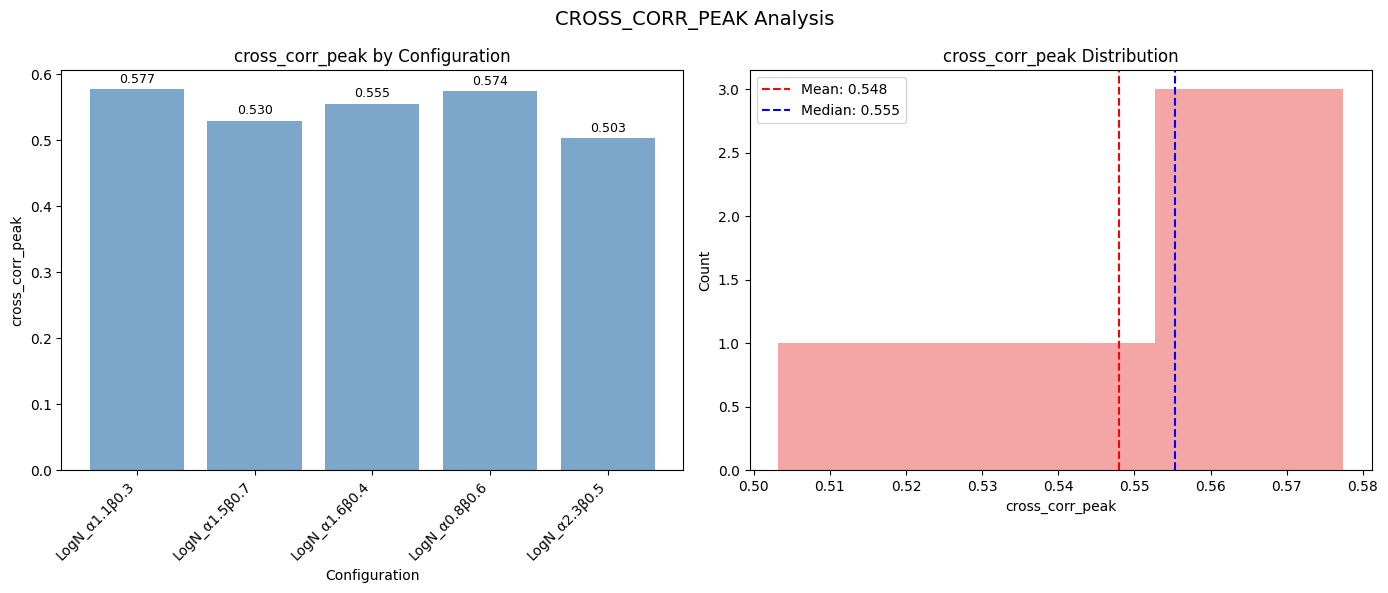

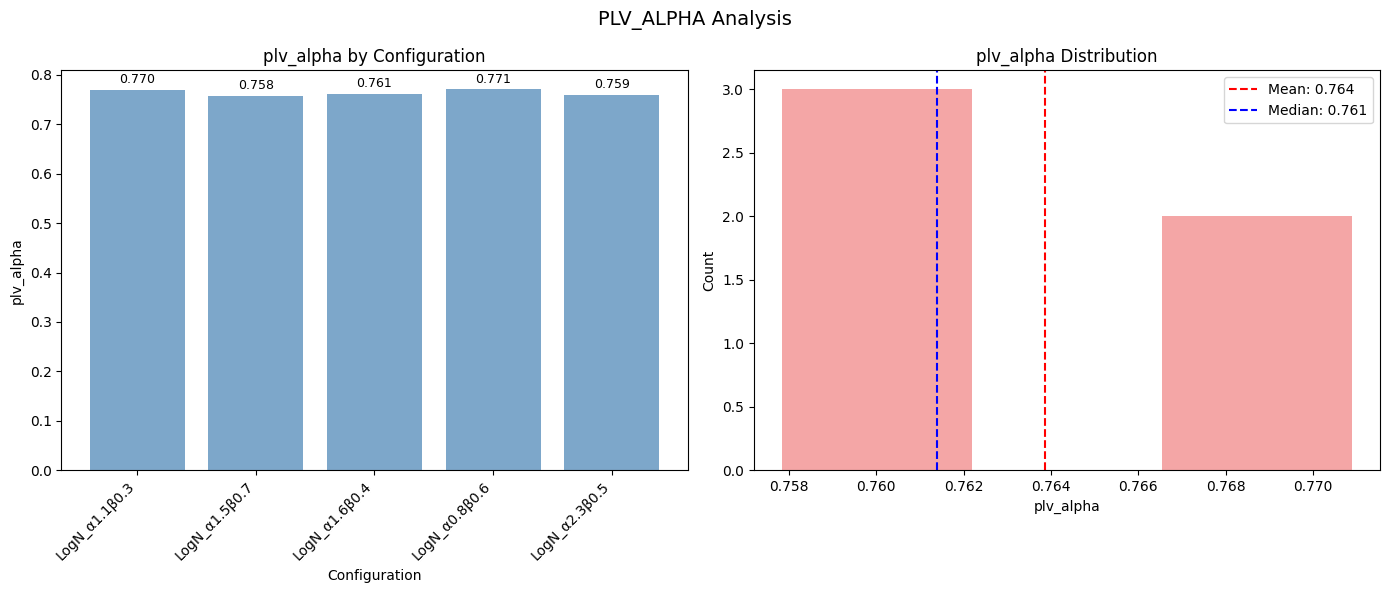

<Figure size 640x480 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt

# =============================================================================
# SIMPLE TIMESERIES ANALYSIS (WORKING VERSION)
# =============================================================================

def create_simple_comparison_plots(results_db, metrics=['plv_alpha', 'cross_corr_peak']):
    """Create simple comparison plots using only CSV data - guaranteed to work"""
    
    if not results_db:
        logger.info("No data available")
        return {}
    
    figures = {}
    
    for metric in metrics:
        # Get all values for this metric
        values = []
        configs = []
        
        for config, data in results_db.items():
            agg = data.get('aggregated', {})
            val = agg.get(metric, {}).get('mean', 0)
            if val > 0:  # Filter out zero values
                values.append(val)
                readable = data.get('readable_name', config[:20])
                configs.append(readable)
        
        if len(values) < 2:
            continue
            
        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(f'{metric.upper()} Analysis', fontsize=14)
        
        # 1. Bar plot of all values
        indices = np.arange(len(configs))
        bars = ax1.bar(indices, values, alpha=0.7, color='steelblue')
        ax1.set_title(f'{metric} by Configuration')
        ax1.set_xlabel('Configuration')
        ax1.set_ylabel(metric)
        ax1.set_xticks(indices)
        ax1.set_xticklabels(configs, rotation=45, ha='right')
        
        # Add value labels on bars
        for i, (bar, val) in enumerate(zip(bars, values)):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 2. Distribution analysis
        ax2.hist(values, bins=min(10, len(values)//2 + 1), alpha=0.7, color='lightcoral')
        ax2.axvline(np.mean(values), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(values):.3f}')
        ax2.axvline(np.median(values), color='blue', linestyle='--', 
                   label=f'Median: {np.median(values):.3f}')
        ax2.set_title(f'{metric} Distribution')
        ax2.set_xlabel(metric)
        ax2.set_ylabel('Count')
        ax2.legend()
        
        plt.tight_layout()
        figures[f'{metric}_comparison'] = fig
    
    return figures

def create_delay_parameter_comparison(results_db):
    """Compare configurations by delay parameters"""
    
    delay_types = {}
    
    for config, data in results_db.items():
        delay_config = data.get('delay_config', {})
        delay_type = delay_config.get('type', 'unknown')
        
        if delay_type not in delay_types:
            delay_types[delay_type] = []
        
        # Get key metrics
        agg = data.get('aggregated', {})
        entry = {
            'config': data.get('readable_name', config[:20]),
            'plv_alpha': agg.get('plv_alpha', {}).get('mean', 0),
            'cc_peak': abs(agg.get('cross_corr_peak', {}).get('mean', 0)),
            'coherence': agg.get('coherence_peak', {}).get('mean', 0),
            'delay_params': delay_config.get('params', delay_config.get('value', 'N/A'))
        }
        delay_types[delay_type].append(entry)
    
    if len(delay_types) < 2:
        return None
        
    fig, axes = plt.subplots(1, len(delay_types), figsize=(5*len(delay_types), 6))
    if len(delay_types) == 1:
        axes = [axes]
        
    fig.suptitle('Comparison by Delay Type', fontsize=14)
    
    for i, (delay_type, entries) in enumerate(delay_types.items()):
        ax = axes[i]
        
        if not entries:
            continue
            
        configs = [e['config'] for e in entries]
        plv_vals = [e['plv_alpha'] for e in entries]
        cc_vals = [e['cc_peak'] for e in entries]
        
        # Scatter plot: PLV vs CC
        scatter = ax.scatter(plv_vals, cc_vals, s=100, alpha=0.7)
        
        # Add labels
        for j, (plv, cc, config) in enumerate(zip(plv_vals, cc_vals, configs)):
            ax.annotate(config[:10], (plv, cc), xytext=(5, 5), 
                       textcoords='offset points', fontsize=8)
        
        ax.set_xlabel('PLV Alpha')
        ax.set_ylabel('CC Peak')
        ax.set_title(f'{delay_type.title()} Delays\n({len(entries)} configs)')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Main execution
if 'results_db' in locals() and results_db:
    logger.info("Creating simple comparison plots...")
    
    # Create metric comparisons
    figures = create_simple_comparison_plots(results_db)
    
    # Create delay comparison
    delay_fig = create_delay_parameter_comparison(results_db)
    if delay_fig:
        figures['delay_comparison'] = delay_fig
    
    if figures:
        logger.info(f"Generated {len(figures)} plots:")
        for name in figures.keys():
            logger.info(f"  - {name}")
        
        # Show plots
        for name, fig in figures.items():
            plt.figure(fig.number)
            plt.show()
    else:
        logger.info("No plots generated - check data")
else:
    logger.info("Need results_db loaded")

In [6]:
def analyze_delay_correlations(results_db, save_plot=False):
    """Analyze correlations with fixed delay extraction"""
    
    if not results_db:
        logger.info("No data available")
        return None, None, None
    
    try:
        from src.two_populations.plots.plots_sweeps import (
            extract_metrics_data, plot_correlation_analysis, print_correlation_summary
        )
        
        from src.two_populations.helpers.helpers import extract_delay_parameters
        
        # Use fixed extraction
        delay_df = extract_delay_parameters(results_db)
        metrics_df = extract_metrics_data(results_db)
        
        if delay_df.empty or metrics_df.empty:
            logger.info("Insufficient data")
            return None, None, None
        
        logger.info(f"Analyzing {len(delay_df)} configurations")
        logger.info(f"Delay columns: {[c for c in delay_df.columns if c not in ['config', 'type']]}")
        logger.info(f"Metrics: {[c for c in metrics_df.columns if c != 'config']}")
        
        fig, corr_matrix, p_matrix = plot_correlation_analysis(delay_df, metrics_df)
        
        if corr_matrix is not None:
            print_correlation_summary(corr_matrix, p_matrix)
        
        return fig, corr_matrix, p_matrix
        
    except Exception as e:
        logger.info(f"Failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Execute
if 'results_db' in locals() and results_db:
    fig, corr_matrix, p_matrix = analyze_delay_correlations(results_db)
    
    if corr_matrix is not None:
        logger.info("\nCorrelation analysis complete")
else:
    logger.info("Need results_db")

/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(
INFO     | __main__:analyze_delay_correlations:23 - Analyzing 5 configurations
INFO     | __main__:analyze_delay_correlations:24 - Delay columns: ['lognorm_alpha', 'lognorm_beta', 'lognorm_mean']
INFO     | __main__:analyze_delay_correlations:25 - Metrics: ['plv_alpha', 'pli_alpha', 'plv_gamma', 'pli_gamma', 'cc_peak', 'cc_lag', 'coherence_peak', 'alpha_coherence', 'gamma_coherence', 'tau_A', 'tau_B', 'tau_avg']


No valid correlations found


INFO     | __main__:plot_delay_distributions:17 - Generating delay distribution comparison for 5 configurations
INFO     | __main__:<module>:41 - Delay distribution comparison generated


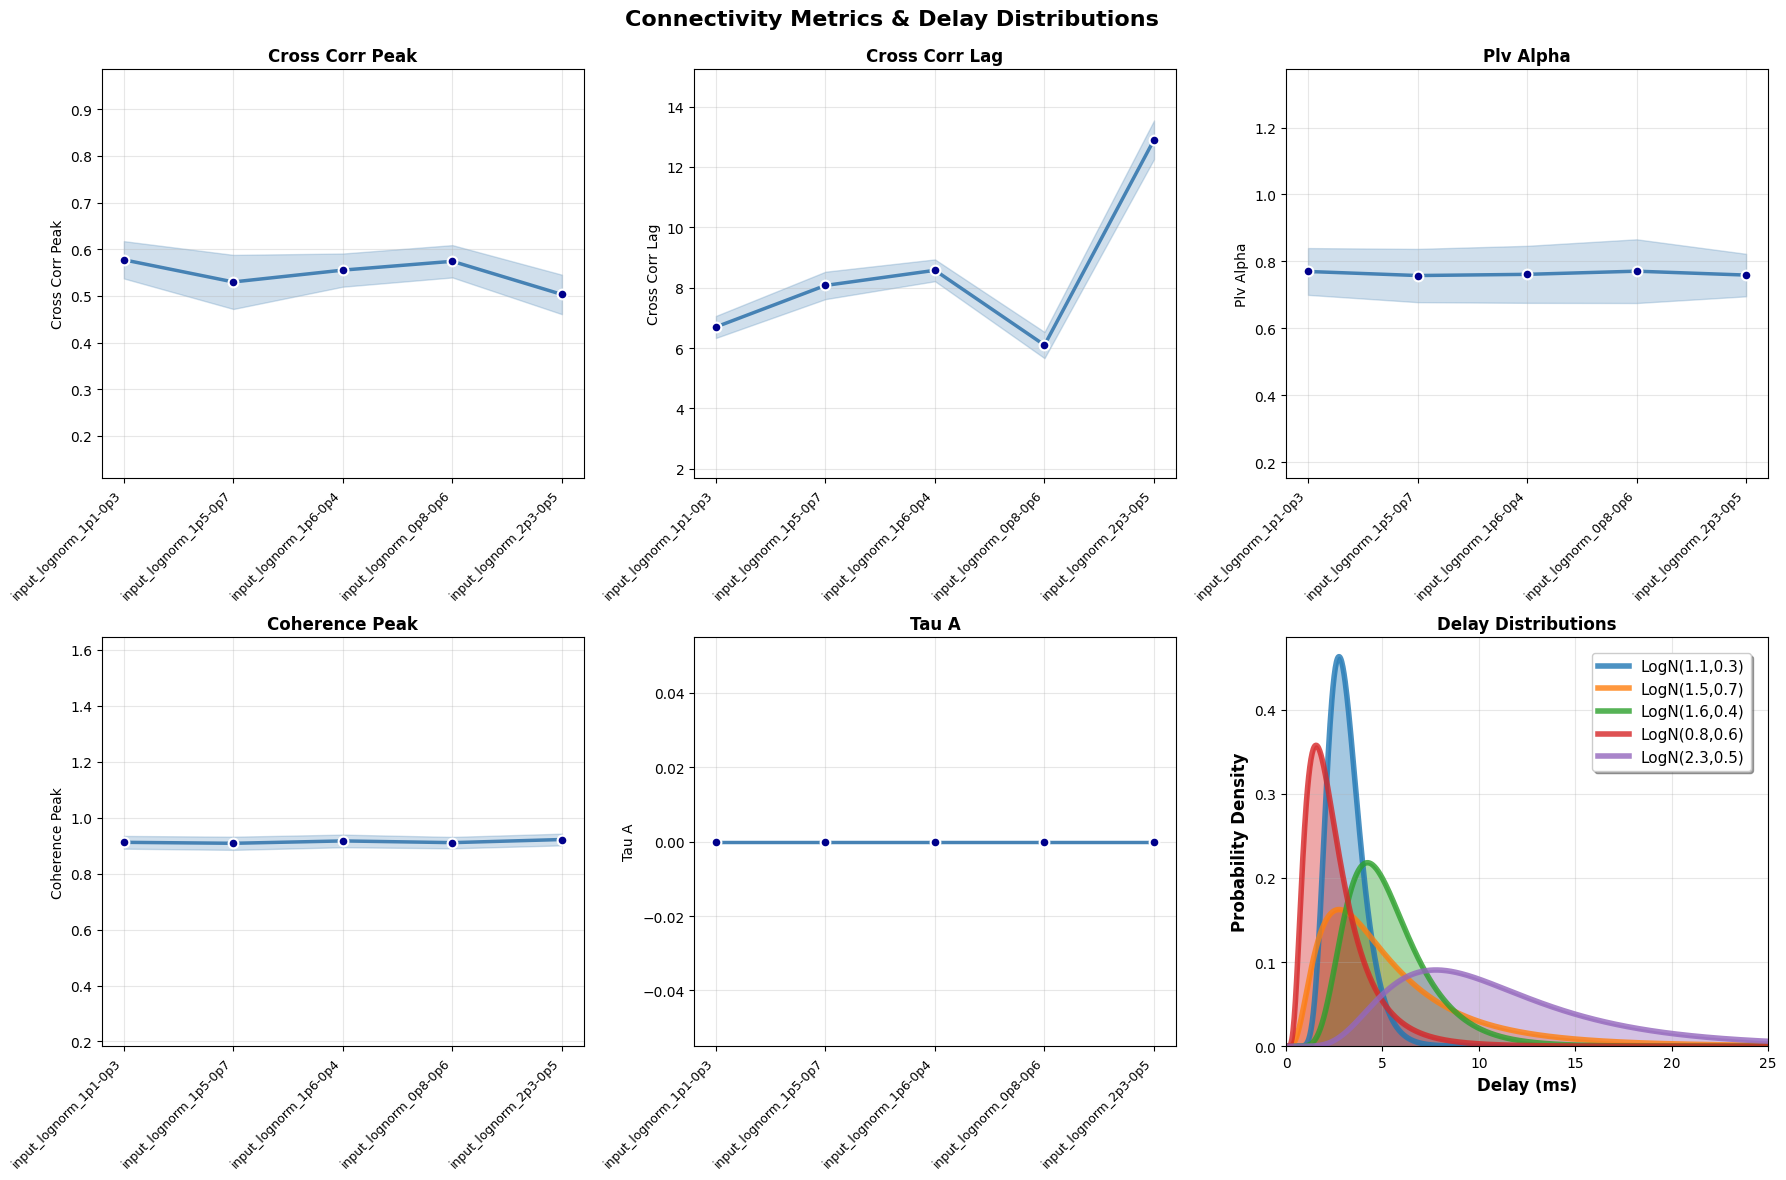

In [7]:
# =============================================================================
# DELAY DISTRIBUTION COMPARISON
# =============================================================================

import matplotlib.pyplot as plt

def plot_delay_distributions(results_db, save_plot=False):
    """Compare delay distributions and their effects on connectivity"""
    
    if not results_db:
        logger.info("No results data available for delay distribution plots")
        return None
    
    try:
        from src.two_populations.sweep import plot_delay_comparison_with_distributions
        
        logger.info(f"Generating delay distribution comparison for {len(results_db)} configurations")
        
        fig = plot_delay_comparison_with_distributions(results_db, save_path=None)
        
        if fig is None:
            logger.info("Failed to generate delay comparison plot")
            return None
        
        if save_plot and 'sweep_dir' in locals():
            save_path = f"{sweep_dir}/figures/delay_distribution_comparison.png"
            fig.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Delay comparison saved to: {save_path}")
        
        return fig
        
    except Exception as e:
        logger.info(f"Delay distribution plot failed: {e}")
        return None

# Generate plot if data is available
if 'results_db' in locals() and results_db:
    fig = plot_delay_distributions(results_db, save_plot=False)
    
    if fig is not None:
        logger.info("Delay distribution comparison generated")
        plt.show()
else:
    logger.info("Delay distribution plotting requires results_db to be loaded")

In [8]:
results_db

{'MS_STRONG_step_input_lognorm_1p1-0p3': {'aggregated': {'cross_corr_peak': {'mean': np.float64(0.5774344883999734),
    'std': np.float64(0.0399647524186801)},
   'cross_corr_lag': {'mean': np.float64(6.699222747504443),
    'std': np.float64(0.3646303785292484)},
   'plv_alpha': {'mean': np.float64(0.7699788293025256),
    'std': np.float64(0.0699140655289637)},
   'coherence_peak': {'mean': np.float64(0.9120092457987802),
    'std': np.float64(0.0227987670801879)}},
  'n_trials': np.int64(20),
  'delay_config': {'type': 'lognormal', 'params': {'alpha': 1.1, 'beta': 0.3}},
  'delay_statistics': {'mean': np.float64(3.143208572259664),
   'std': np.float64(0.9644784437064172),
   'n_connections': np.int64(398840)},
  'readable_name': 'LogN_α1.1β0.3'},
 'MS_STRONG_step_input_lognorm_1p5-0p7': {'aggregated': {'cross_corr_peak': {'mean': np.float64(0.529973090255133),
    'std': np.float64(0.0579913250657792)},
   'cross_corr_lag': {'mean': np.float64(8.07517638920243),
    'std': np.floa

INFO     | __main__:<module>:4 - 
[PLOTS] Generating comprehensive visualizations...
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/plots_sweeps.py:299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
INFO     | src.two_populations.plots.plots_sweeps:save_all_sweep_plots:967 - 
Analyzing 5 configurations
INFO     | src.two_populations.plots.plots_sweeps:save_all_sweep_plots:968 - Delay statistics: ['mean', 'median', 'std', 'iqr', 'range', 'cv', 'skewness', 'kurtosis', 'min', 'max', 'q25', 'q75']
INFO     | src.two_populations.plots.plots_sweeps:save_all_sweep_plots:969 - Connectivity metrics: ['plv_alpha', 'pli_alpha', 'plv_gamma', 'pli_gamma', 'cc_peak', 'cc_lag', 'coherence_peak', 'alpha_coherence', 'gamma_coherence', 'tau_A', 'tau_B', 'tau_avg']
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/plots/plots_sweeps.py:716: ConstantInpu


SIGNIFICANT CORRELATIONS (p < 0.05)

MEAN:
  ↓ CC_PEAK: r=-0.948 (STRONG, p=0.0143)
  ↑ CC_LAG: r=+0.994 (STRONG, p=0.0006)

STD:
  ↓ CC_PEAK: r=-0.989 (STRONG, p=0.0014)



INFO     | src.two_populations.plots.plots_sweeps:save_all_sweep_plots:989 - [SAVED] 3 figures total


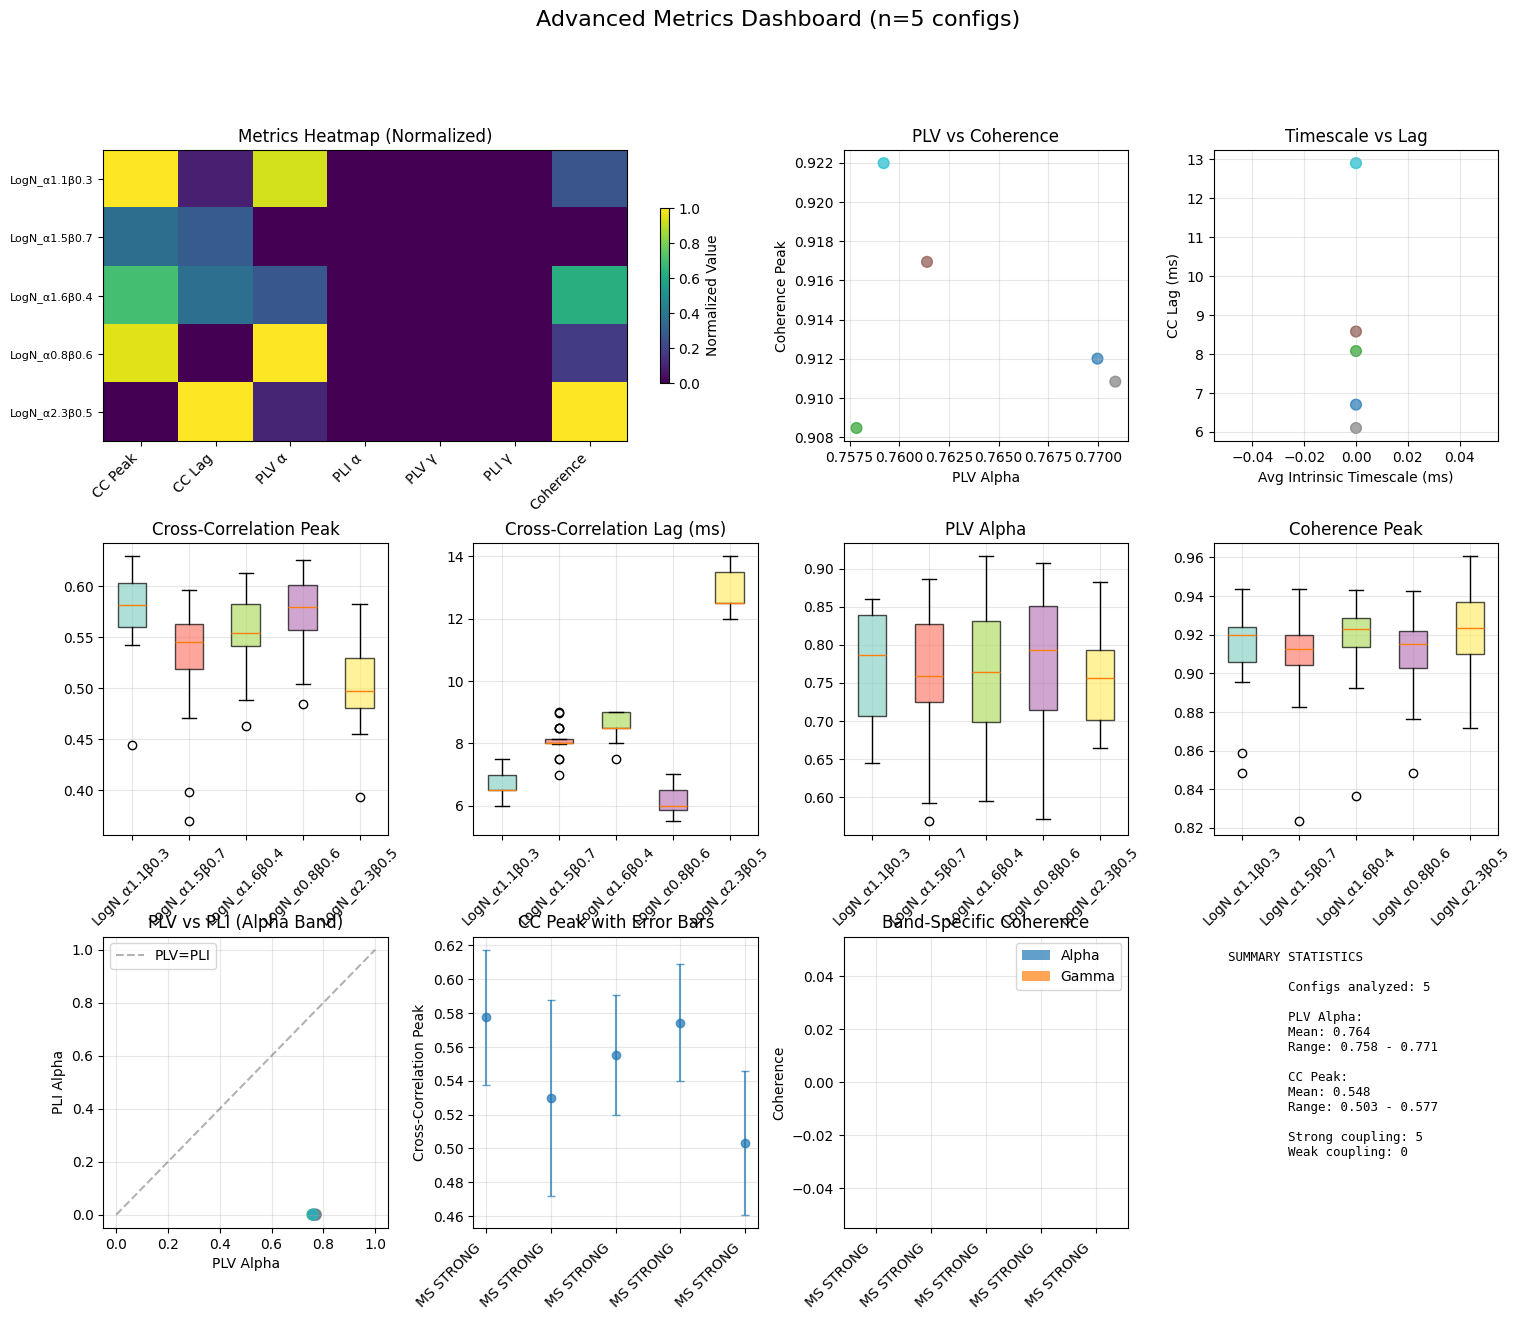

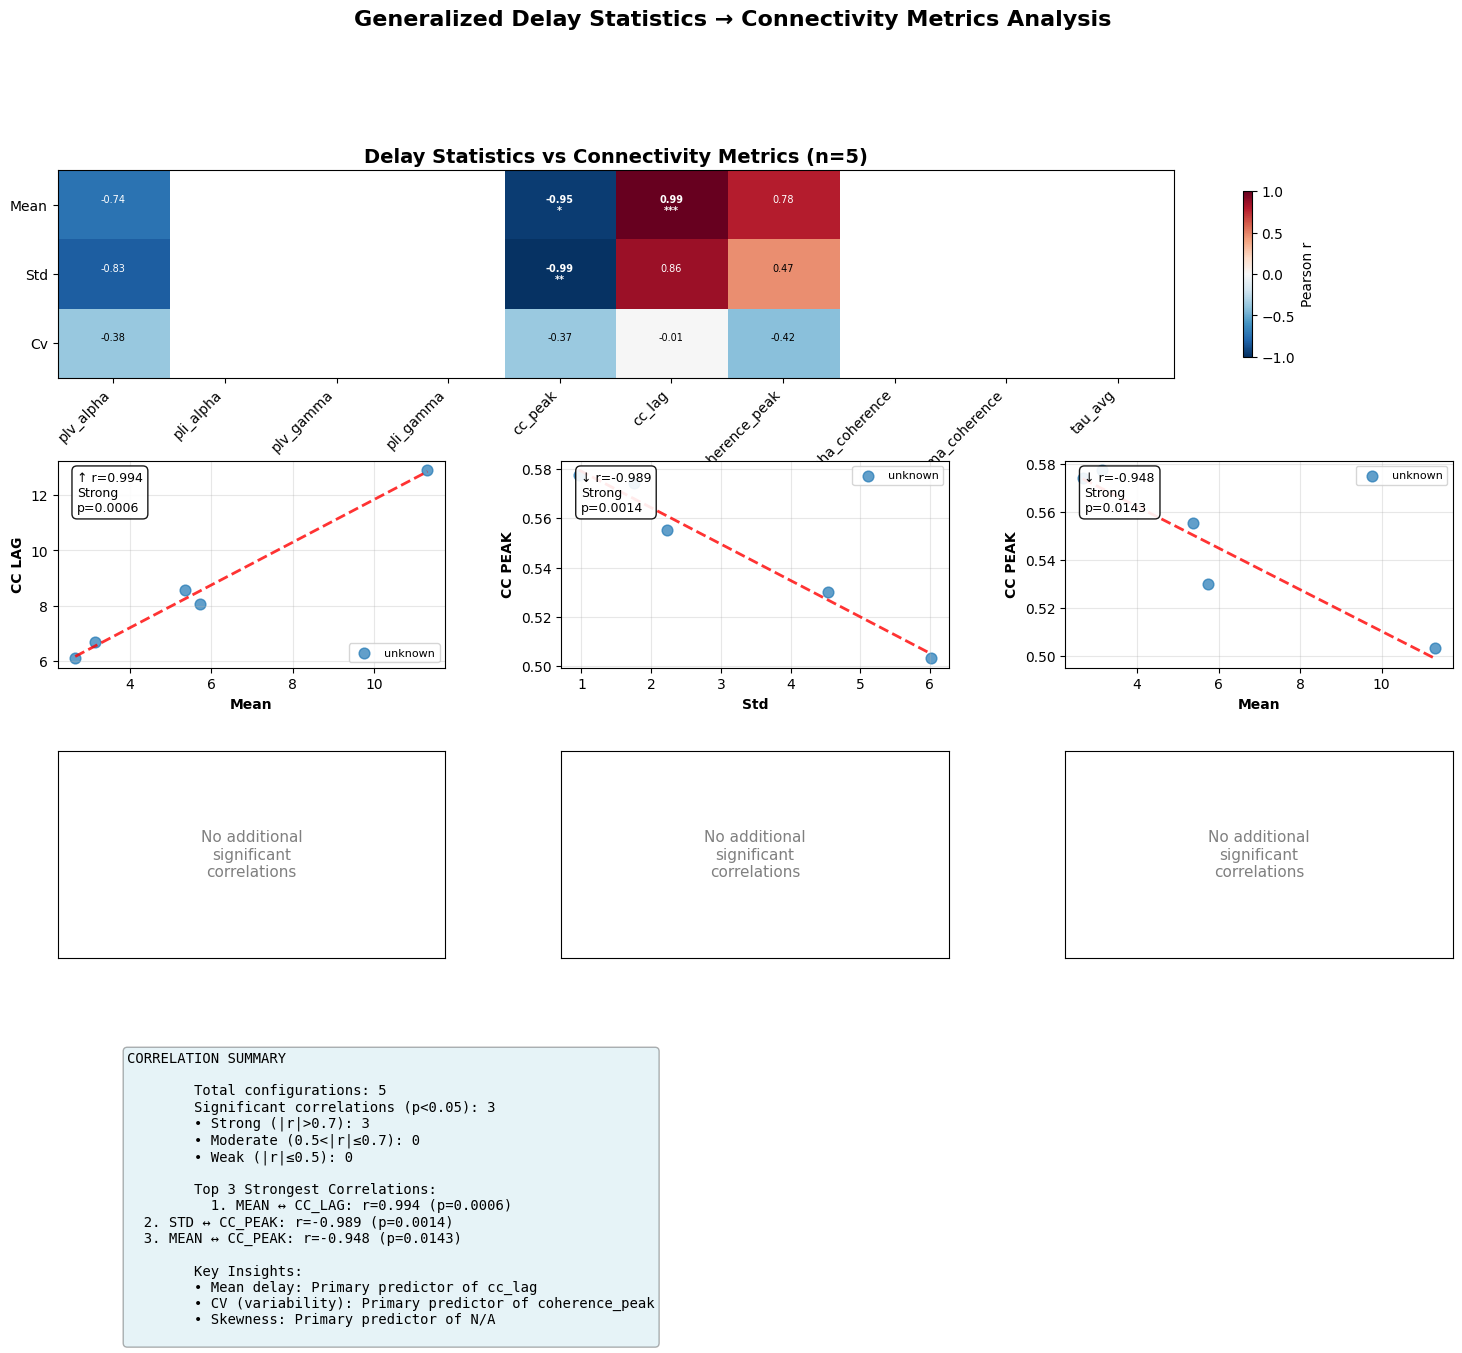

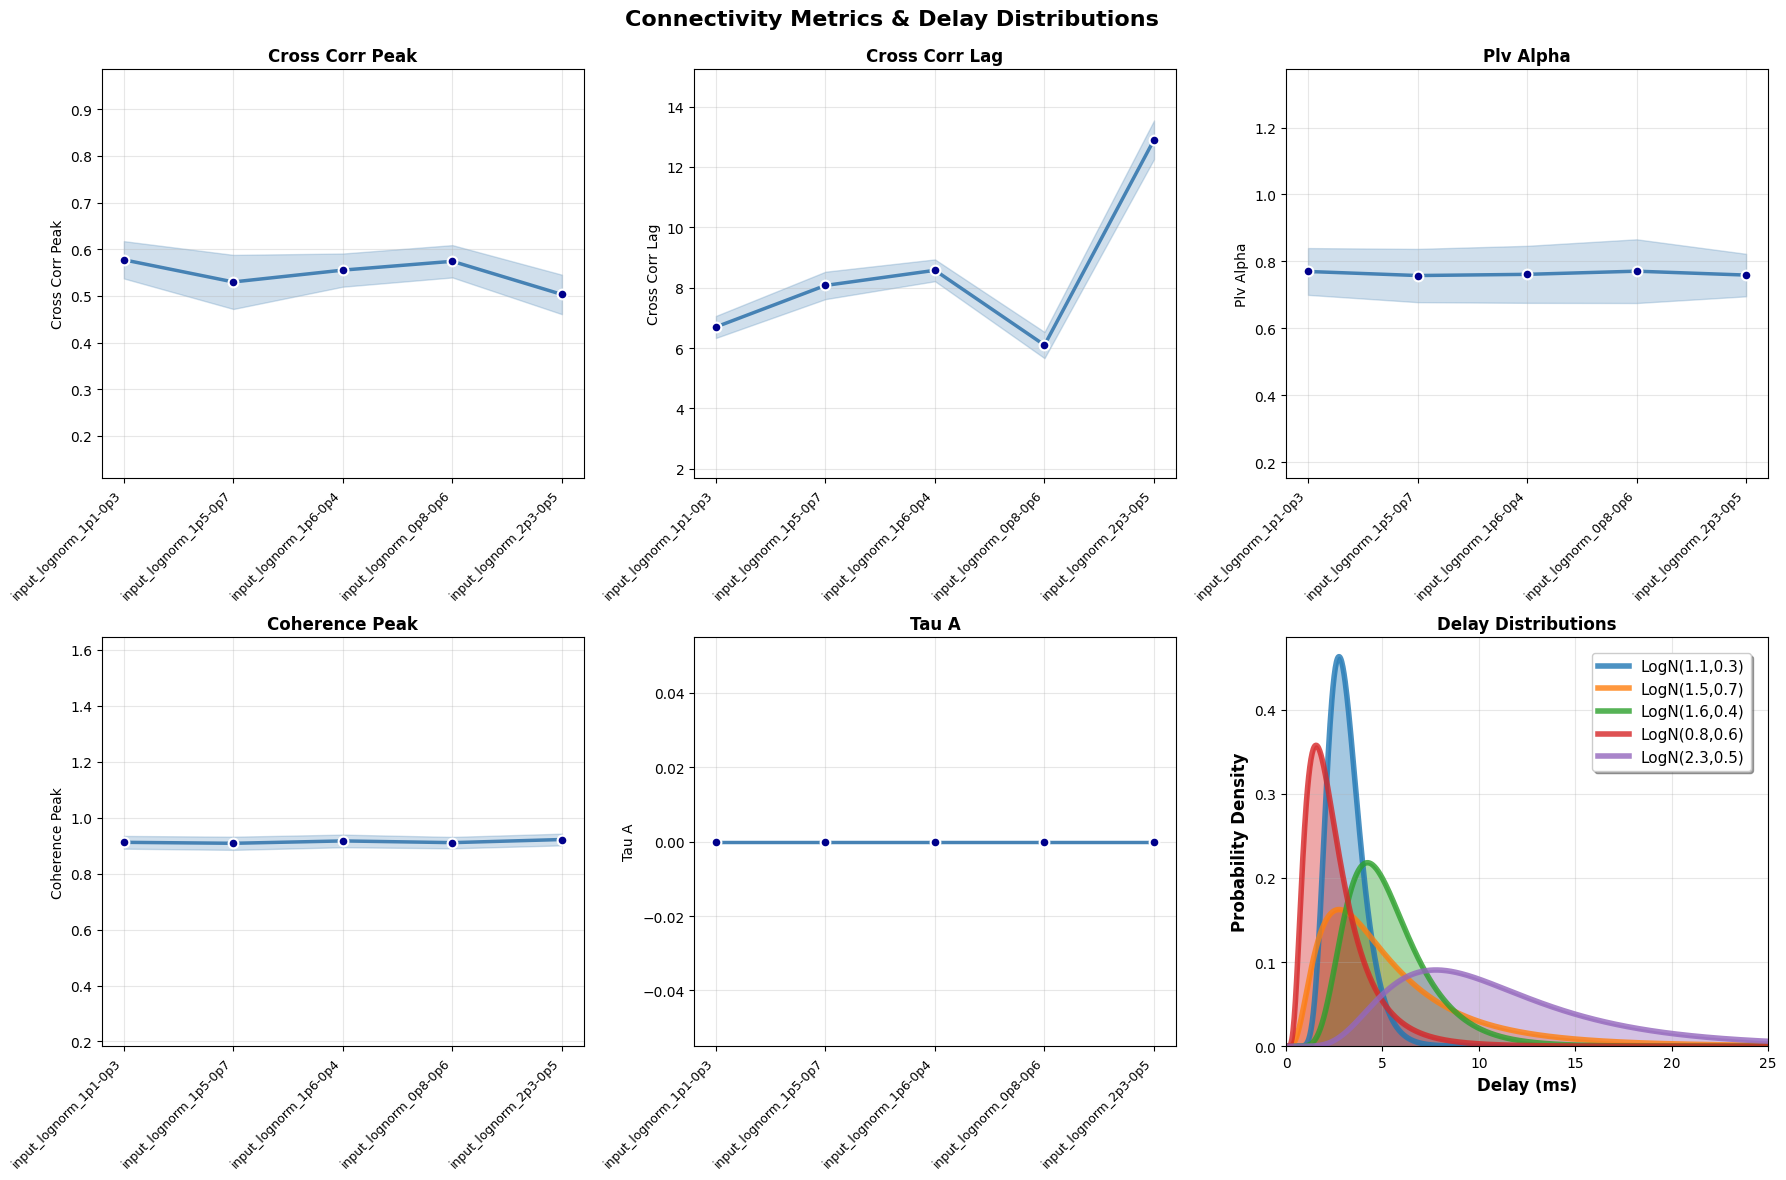

In [9]:
from src.two_populations.plots.plots_sweeps import save_all_sweep_plots


logger.info("\n[PLOTS] Generating comprehensive visualizations...")
figures, corr_matrix, p_matrix, delay_df, metrics_df = save_all_sweep_plots(sweep_dir, results_db, trials_data, dpi=300, auto_save=False)
